#ANÁLISE DE REVIEWS DO STEAM

###DESCRIÇÃO DO PROJETO

Conjunto de dados: Reviews do Steam.

O conjunto de dados pode ser encontrado no seguinte link: https://www.kaggle.com/datasets/yukawithdata/steam-review-stats-dataset.

Este projeto conterá os seguintes três tópicos apresentados na disciplina:

*  Sumarização de texto: resume os reviews, de forma a preservar as partes mais relevantes, tornando o processamento seguinte mais rápido.
*  Análise de sentimento: analisa o sentimento dos reviews gerados pelos usuários.
*  Modelagem de Tópicos: busca colher feedback dos usuários por meio de seus reviews, tentando identificar tendências.



In [115]:
#Importando o arquivo do google drive
import requests
import zipfile
from io import BytesIO

# ID do arquivo zip no Google Drive. O zip foi baixado do site mencionado acima. Não conta com nenhum tratamento, o que irá ocorrer ao longo deste código.
#O link original de compartilhamento do zip é https://drive.google.com/file/d/1Ei9jO0kK1oPFO_-TASB4bIsJNRC6HTKQ/view?usp=share_link
file_id = "1Ei9jO0kK1oPFO_-TASB4bIsJNRC6HTKQ"

# URL de download do arquivo zip.
url = f"https://drive.google.com/uc?id={file_id}&export=download"

# Faz o download do arquivo zip.
response = requests.get(url)
file_bytes = BytesIO(response.content)

# Extrai o arquivo zip.
with zipfile.ZipFile(file_bytes, "r") as zip_ref:
    zip_ref.extractall()

Utilização do pandas para leitura do .csv que contém a base de dados acima. O documento é intitulado *tableau_steam.csv*.

In [116]:
import pandas as pd

# Lê o arquivo csv da base de dados extraída acima. Imprime-a para que verifiquemos seu conteúdo.
df = pd.read_csv('/content/tableau_steam.csv')

df

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,title,ave_sentiment,word_count,new_review
0,2017-06-20,85,2139,612,False,Recommended,Dead by Daylight,-0.091786,260,Disclaimer I survivor main I play for fun not...
1,2018-12-24,295,219,71,False,Recommended,Dead by Daylight,0.041603,13,I have never been told to kill myself more tha...
2,2018-12-05,380,271,414,False,Recommended,Dead by Daylight,-0.166667,9,if you think cs go is toxic try this
3,2018-12-04,11,106,900,False,Recommended,Dead by Daylight,-0.215483,290,This is simultaneously the most fun and most i...
4,2018-01-16,88,614,1878,False,Recommended,Dead by Daylight,-0.019964,310,Kids Everyone Casual players Pro players Graph...
...,...,...,...,...,...,...,...,...,...,...
260901,2018-11-15,2,110,44,False,Recommended,"Warhammer 40,000: Mechanicus",0.769526,954,Mechanicus is a that shares a few similaritie...
260902,2018-11-17,1,37,10,False,Recommended,"Warhammer 40,000: Mechanicus",0.437147,327,YOUR FLESH WILL ROT AND DECAYSTEEL IS IMMORTAL...
260903,2018-11-20,0,0,36,False,Recommended,"Warhammer 40,000: Mechanicus",0.353553,128,First off if you like X Com style of you will...
260904,2018-11-18,1,44,12,False,Recommended,"Warhammer 40,000: Mechanicus",0.630964,328,As a disclaimer Im an AdMech player on the tab...


#PRÉ-PROCESSAMENTO DE DADOS

Neste pré-processamento, realizaremos algumas etapas importantes que tornarão as implementações futuras mais eficientes (e possíveis):

* Remoção de reviews vazios.
* Conversão de todo o texto para letras minúsculas.
* Remoção de caracteres especiais e possíveis pontuações.
* Tokenização
* Remoção de stopwords

In [117]:
# Verificando valores nulos.
df.isnull().sum()

date_posted                  0
funny                        0
helpful                      0
hour_played                  0
is_early_access_review       0
recommendation               0
title                        0
ave_sentiment                0
word_count                   0
new_review                3186
dtype: int64

In [118]:
# Remove os valores nulos/vazios
df= df.dropna()
df = df.reset_index(drop=True)

df.isnull().sum()

date_posted               0
funny                     0
helpful                   0
hour_played               0
is_early_access_review    0
recommendation            0
title                     0
ave_sentiment             0
word_count                0
new_review                0
dtype: int64

In [119]:
# Lista de contractions do inglês, para que tratemos melhor o texto. Essa lista pode ser encontrada em http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}


def replace_contractions(text):
    for key, value in contractions.items():
        text = text.replace(key, value)
    return text

#Cria uma nova coluna, removendo as contrações. Usaremos essa coluna para limpar o texto posteriormente.
df['clean_review'] = df['new_review'].apply(replace_contractions)

In [120]:
# Importando as bibliotecas necessárias

import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [121]:
# Função para remover números da string.
def remove_numbers(text):
    result = ''.join([i for i in text if not i.isdigit()])
    return result

# Aplicando a função na coluna 'new_review'.
df['clean_review'] = df['clean_review'].apply(remove_numbers)

# Converte todos os reviews para letras minúsculas.
df['clean_review'] = df['clean_review'].apply(lambda x: x.lower())

# Remoção de pontuação.
df['clean_review'] = df['clean_review'].apply(lambda x: re.sub('[^\w\s]','',x))

# Tokenização.
df['clean_review'] = df['clean_review'].apply(lambda x: word_tokenize(x))

# Remoção de stop words.
stop_words = set(stopwords.words('english'))
df['clean_review'] = df['clean_review'].apply(lambda x: [word for word in x if word not in stop_words])


# Forma novamente o texto.
df['text_review'] = df['clean_review'].apply(lambda x: ' '.join(x))

df

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,title,ave_sentiment,word_count,new_review,clean_review,text_review
0,2017-06-20,85,2139,612,False,Recommended,Dead by Daylight,-0.091786,260,Disclaimer I survivor main I play for fun not...,"[disclaimer, survivor, main, play, fun, compet...",disclaimer survivor main play fun competition ...
1,2018-12-24,295,219,71,False,Recommended,Dead by Daylight,0.041603,13,I have never been told to kill myself more tha...,"[never, told, kill, playing]",never told kill playing
2,2018-12-05,380,271,414,False,Recommended,Dead by Daylight,-0.166667,9,if you think cs go is toxic try this,"[think, cs, go, toxic, try]",think cs go toxic try
3,2018-12-04,11,106,900,False,Recommended,Dead by Daylight,-0.215483,290,This is simultaneously the most fun and most i...,"[simultaneously, fun, infuriating, ive, played...",simultaneously fun infuriating ive played long...
4,2018-01-16,88,614,1878,False,Recommended,Dead by Daylight,-0.019964,310,Kids Everyone Casual players Pro players Graph...,"[kids, everyone, casual, players, pro, players...",kids everyone casual players pro players graph...
...,...,...,...,...,...,...,...,...,...,...,...,...
257715,2018-11-15,2,110,44,False,Recommended,"Warhammer 40,000: Mechanicus",0.769526,954,Mechanicus is a that shares a few similaritie...,"[mechanicus, shares, similarities, xcom, howev...",mechanicus shares similarities xcom however lo...
257716,2018-11-17,1,37,10,False,Recommended,"Warhammer 40,000: Mechanicus",0.437147,327,YOUR FLESH WILL ROT AND DECAYSTEEL IS IMMORTAL...,"[flesh, rot, decaysteel, immortalfor, omnissia...",flesh rot decaysteel immortalfor omnissiahthis...
257717,2018-11-20,0,0,36,False,Recommended,"Warhammer 40,000: Mechanicus",0.353553,128,First off if you like X Com style of you will...,"[first, like, x, com, style, likely, like, lik...",first like x com style likely like like warham...
257718,2018-11-18,1,44,12,False,Recommended,"Warhammer 40,000: Mechanicus",0.630964,328,As a disclaimer Im an AdMech player on the tab...,"[disclaimer, im, admech, player, tabletop, rev...",disclaimer im admech player tabletop review go...


In [122]:
# Substituamos os valores não numéricos por numéricos. Além disso, como não haverá análise entre review e data de postagem, removamos a coluna de data.

# Substituição dos valores booleanos por 1 e 0
df['is_early_access_review'] = df['is_early_access_review'].map({True: 1, False: 0})
df['recommendation'] = df['recommendation'].map({'Recommended': 1, 'Not Recommended': 0})

df

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,title,ave_sentiment,word_count,new_review,clean_review,text_review
0,2017-06-20,85,2139,612,0,1,Dead by Daylight,-0.091786,260,Disclaimer I survivor main I play for fun not...,"[disclaimer, survivor, main, play, fun, compet...",disclaimer survivor main play fun competition ...
1,2018-12-24,295,219,71,0,1,Dead by Daylight,0.041603,13,I have never been told to kill myself more tha...,"[never, told, kill, playing]",never told kill playing
2,2018-12-05,380,271,414,0,1,Dead by Daylight,-0.166667,9,if you think cs go is toxic try this,"[think, cs, go, toxic, try]",think cs go toxic try
3,2018-12-04,11,106,900,0,1,Dead by Daylight,-0.215483,290,This is simultaneously the most fun and most i...,"[simultaneously, fun, infuriating, ive, played...",simultaneously fun infuriating ive played long...
4,2018-01-16,88,614,1878,0,1,Dead by Daylight,-0.019964,310,Kids Everyone Casual players Pro players Graph...,"[kids, everyone, casual, players, pro, players...",kids everyone casual players pro players graph...
...,...,...,...,...,...,...,...,...,...,...,...,...
257715,2018-11-15,2,110,44,0,1,"Warhammer 40,000: Mechanicus",0.769526,954,Mechanicus is a that shares a few similaritie...,"[mechanicus, shares, similarities, xcom, howev...",mechanicus shares similarities xcom however lo...
257716,2018-11-17,1,37,10,0,1,"Warhammer 40,000: Mechanicus",0.437147,327,YOUR FLESH WILL ROT AND DECAYSTEEL IS IMMORTAL...,"[flesh, rot, decaysteel, immortalfor, omnissia...",flesh rot decaysteel immortalfor omnissiahthis...
257717,2018-11-20,0,0,36,0,1,"Warhammer 40,000: Mechanicus",0.353553,128,First off if you like X Com style of you will...,"[first, like, x, com, style, likely, like, lik...",first like x com style likely like like warham...
257718,2018-11-18,1,44,12,0,1,"Warhammer 40,000: Mechanicus",0.630964,328,As a disclaimer Im an AdMech player on the tab...,"[disclaimer, im, admech, player, tabletop, rev...",disclaimer im admech player tabletop review go...


# Sumarização de texto

Nesta etapa, façamos uma sumarização dos reviews. Sumarizá-los tornará as etapas posteriores mais rápidas e eficientes.

Como o objetivo é resumir um review de jogo, a sumarização extrativa será mais adequada, pois extrairemos as informações relevantes de forma a condensá-las em uma informação sucinta que será utilizada na posterior análise de sentimento.

In [123]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist
from heapq import nlargest

nltk.download('punkt')

# função para realizar a sumarização
def summarize_text(text, n):
    sentences = sent_tokenize(text)
    word_frequencies = FreqDist(sentences)
    most_frequent_sentences = nlargest(n, word_frequencies, key=word_frequencies.get)
    summary = ' '.join(most_frequent_sentences)
    return summary

# exemplo de uso da função de sumarização para obter um resumo dos 3 principais tópicos dos textos da coluna "text_review"
n = 3
df['summary'] = df['text_review'].apply(lambda x: summarize_text(x, n))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [124]:
# Imprime n exemplos de textos sumarizados, mostrando o texto não sumarizado da coluna 'new_review' e a sumarização da coluna 'summary'.
def print_review_summary(df, n=5):
    for i, row in df.sample(n).iterrows():
        print(f"Review: {row['new_review']}")
        print(f"Summary: {row['summary']}\n")

print('Exemplos de reviews e seu respectivo resumo:\n')
print_review_summary(df, 10)

Exemplos de reviews e seu respectivo resumo:

Review: The  has a few glitches here and there but its atleast one of the best  me and my friend have played
Summary: glitches atleast one best friend played

Review: The campaign is superbly done that I almost forgot about the horrendous multiplayer experience
Summary: campaign superbly done almost forgot horrendous multiplayer experience

Review: It has hats
Summary: hats

Review: This  takes you back to the start screen every time you die It might seem petty but going through  loadingconnecting screens before a actual match even begins to load is really stupid If there was just a button that put you in another match when you diedlost it would he much smoother and much less agonizing The playable area shrinks really fast Theres nothing like spending the entire play time running to a safe zone just to be told thats its shrinking again Then getting shot in the back by someone who has the same issue as you but slightly worse Cars arent commo

Façamos agora algumas estatísticas a respeito da sumarização realizada.

In [125]:
# Calcula a quantidade de palavras dos textos originais.
df["word_count_review"] = df["new_review"].apply(lambda x: len(x.split()))

# Calcula a quantidade de palavras dos textos sumarizados.
df["word_count_summary"] = df["summary"].apply(lambda x: len(x.split()))

# Calcula a média de palavras dos textos originais.
mean_word_count_review = df["word_count_review"].mean()

# Calcula a média de palavras dos textos sumarizados.
mean_word_count_summary = df["word_count_summary"].mean()

# Calcula a diferença percentual entre a quantidade de palavras dos textos originais e dos textos sumarizados.
diff_percent = 100 * (mean_word_count_review - mean_word_count_summary) / mean_word_count_review

# Imprime as estatísticas.
print("Média de palavras dos textos originais:", mean_word_count_review)
print("Média de palavras dos textos sumarizados:", mean_word_count_summary)
print("Diferença percentual:", diff_percent)

Média de palavras dos textos originais: 38.98182135651094
Média de palavras dos textos sumarizados: 20.520367065031817
Diferença percentual: 47.35913728257748


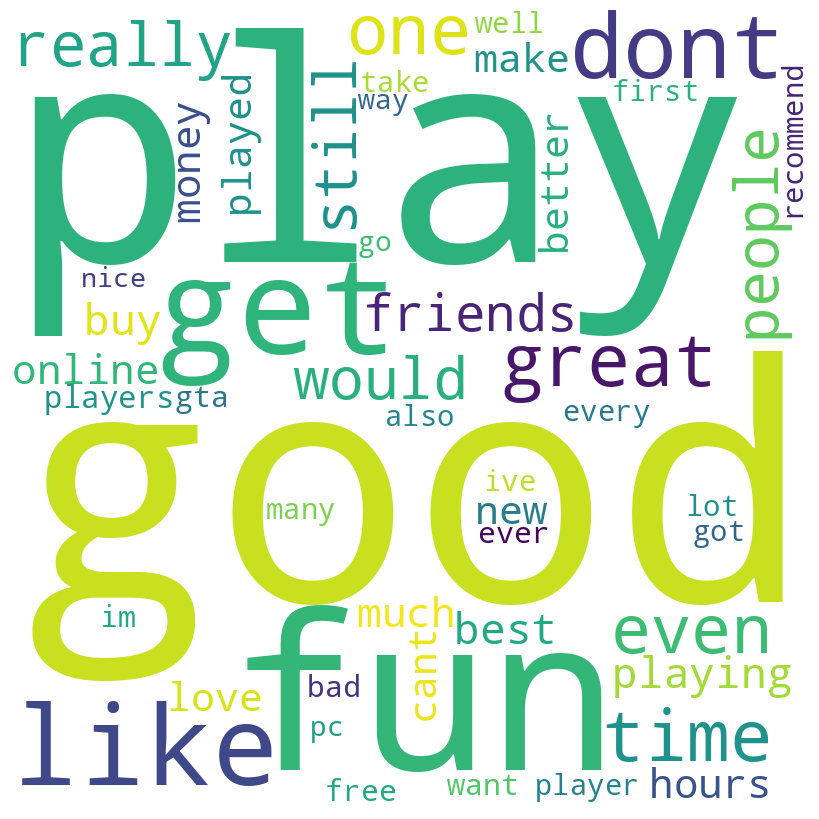

In [126]:
# Wordcloud para as palavras mais comuns.
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Juntando todas as sumarizações em uma única string.
all_summaries = ' '.join(df['summary'])

# Contando a frequência das palavras.
word_counts = Counter(all_summaries.split())

# Gerando a wordcloud com as 50 palavras mais comuns.
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', 
                min_font_size = 10, max_words=50).generate_from_frequencies(word_counts)

# Plotando a wordcloud.
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# Análise de sentimento

Façamos, a partir dos reviews sumarizados, uma análise de sentimento usando textblob.

In [135]:
from textblob import TextBlob

# Criando uma nova coluna 'sentiment' com o sentimento de cada review.
df['sentiment'] = df['summary'].apply(lambda x: TextBlob(x).sentiment.polarity)

df

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,title,ave_sentiment,word_count,new_review,clean_review,text_review,summary,word_count_review,word_count_summary,sentiment,sentiment_category
0,2017-06-20,85,2139,612,0,1,Dead by Daylight,-0.091786,260,Disclaimer I survivor main I play for fun not...,"[disclaimer, survivor, main, play, fun, compet...",disclaimer survivor main play fun competition ...,disclaimer survivor main play fun competition ...,260,131,0.035321,Neutro
1,2018-12-24,295,219,71,0,1,Dead by Daylight,0.041603,13,I have never been told to kill myself more tha...,"[never, told, kill, playing]",never told kill playing,never told kill playing,13,4,0.000000,Neutro
2,2018-12-05,380,271,414,0,1,Dead by Daylight,-0.166667,9,if you think cs go is toxic try this,"[think, cs, go, toxic, try]",think cs go toxic try,think cs go toxic try,9,5,0.000000,Neutro
3,2018-12-04,11,106,900,0,1,Dead by Daylight,-0.215483,290,This is simultaneously the most fun and most i...,"[simultaneously, fun, infuriating, ive, played...",simultaneously fun infuriating ive played long...,simultaneously fun infuriating ive played long...,290,162,-0.012574,Neutro
4,2018-01-16,88,614,1878,0,1,Dead by Daylight,-0.019964,310,Kids Everyone Casual players Pro players Graph...,"[kids, everyone, casual, players, pro, players...",kids everyone casual players pro players graph...,kids everyone casual players pro players graph...,310,185,0.120817,Neutro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257715,2018-11-15,2,110,44,0,1,"Warhammer 40,000: Mechanicus",0.769526,954,Mechanicus is a that shares a few similaritie...,"[mechanicus, shares, similarities, xcom, howev...",mechanicus shares similarities xcom however lo...,mechanicus shares similarities xcom however lo...,954,469,0.148808,Neutro
257716,2018-11-17,1,37,10,0,1,"Warhammer 40,000: Mechanicus",0.437147,327,YOUR FLESH WILL ROT AND DECAYSTEEL IS IMMORTAL...,"[flesh, rot, decaysteel, immortalfor, omnissia...",flesh rot decaysteel immortalfor omnissiahthis...,flesh rot decaysteel immortalfor omnissiahthis...,327,166,0.084959,Neutro
257717,2018-11-20,0,0,36,0,1,"Warhammer 40,000: Mechanicus",0.353553,128,First off if you like X Com style of you will...,"[first, like, x, com, style, likely, like, lik...",first like x com style likely like like warham...,first like x com style likely like like warham...,128,65,0.213542,Positivo
257718,2018-11-18,1,44,12,0,1,"Warhammer 40,000: Mechanicus",0.630964,328,As a disclaimer Im an AdMech player on the tab...,"[disclaimer, im, admech, player, tabletop, rev...",disclaimer im admech player tabletop review go...,disclaimer im admech player tabletop review go...,328,168,0.130449,Neutro


In [137]:
# Definindo os limites para as categorias de sentimento.
positive_lim = 0.1 #acima de 0.1 o sentimento é positivo
negative_lim = -0.1 #abaixo de -0.1 é negativo
# Caso esteja entre os dois limites, o sentimento será neutro.

# Criando uma nova coluna 'sentiment_category' com as categorias de sentimento.
df['sentiment_category'] = df['sentiment'].apply(lambda x: 'Positive' if x >= positive_lim else ('Negative' if x <= negative_lim else 'Neutral'))

df

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,title,ave_sentiment,word_count,new_review,clean_review,text_review,summary,word_count_review,word_count_summary,sentiment,sentiment_category
0,2017-06-20,85,2139,612,0,1,Dead by Daylight,-0.091786,260,Disclaimer I survivor main I play for fun not...,"[disclaimer, survivor, main, play, fun, compet...",disclaimer survivor main play fun competition ...,disclaimer survivor main play fun competition ...,260,131,0.035321,Neutral
1,2018-12-24,295,219,71,0,1,Dead by Daylight,0.041603,13,I have never been told to kill myself more tha...,"[never, told, kill, playing]",never told kill playing,never told kill playing,13,4,0.000000,Neutral
2,2018-12-05,380,271,414,0,1,Dead by Daylight,-0.166667,9,if you think cs go is toxic try this,"[think, cs, go, toxic, try]",think cs go toxic try,think cs go toxic try,9,5,0.000000,Neutral
3,2018-12-04,11,106,900,0,1,Dead by Daylight,-0.215483,290,This is simultaneously the most fun and most i...,"[simultaneously, fun, infuriating, ive, played...",simultaneously fun infuriating ive played long...,simultaneously fun infuriating ive played long...,290,162,-0.012574,Neutral
4,2018-01-16,88,614,1878,0,1,Dead by Daylight,-0.019964,310,Kids Everyone Casual players Pro players Graph...,"[kids, everyone, casual, players, pro, players...",kids everyone casual players pro players graph...,kids everyone casual players pro players graph...,310,185,0.120817,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257715,2018-11-15,2,110,44,0,1,"Warhammer 40,000: Mechanicus",0.769526,954,Mechanicus is a that shares a few similaritie...,"[mechanicus, shares, similarities, xcom, howev...",mechanicus shares similarities xcom however lo...,mechanicus shares similarities xcom however lo...,954,469,0.148808,Positive
257716,2018-11-17,1,37,10,0,1,"Warhammer 40,000: Mechanicus",0.437147,327,YOUR FLESH WILL ROT AND DECAYSTEEL IS IMMORTAL...,"[flesh, rot, decaysteel, immortalfor, omnissia...",flesh rot decaysteel immortalfor omnissiahthis...,flesh rot decaysteel immortalfor omnissiahthis...,327,166,0.084959,Neutral
257717,2018-11-20,0,0,36,0,1,"Warhammer 40,000: Mechanicus",0.353553,128,First off if you like X Com style of you will...,"[first, like, x, com, style, likely, like, lik...",first like x com style likely like like warham...,first like x com style likely like like warham...,128,65,0.213542,Positive
257718,2018-11-18,1,44,12,0,1,"Warhammer 40,000: Mechanicus",0.630964,328,As a disclaimer Im an AdMech player on the tab...,"[disclaimer, im, admech, player, tabletop, rev...",disclaimer im admech player tabletop review go...,disclaimer im admech player tabletop review go...,328,168,0.130449,Positive


Tendo a análise de sentimento sido feita para cada review, façamos agora uma busca pelos 5 jogos que mais geraram sentimento positivo e os 5 que mais geraram sentimento negativo.

In [138]:
# Selecionando os 5 jogos com sentimento mais positivo.
positive_reviews = df[['title', 'sentiment']].groupby('title').mean().sort_values('sentiment', ascending=False).head(5)

# Selecionando os 5 jogos com sentimento mais negativo.
negative_reviews = df[['title', 'sentiment']].groupby('title').mean().sort_values('sentiment', ascending=True).head(5)

# Imprimindo os resultados.
print('Os 5 jogos com sentimentos mais positivos:')
print(positive_reviews)

print('\nOs 5 jogos com sentimentos mais negativos:')
print(negative_reviews)

Os 5 jogos com sentimentos mais positivos:
                        sentiment
title                            
Wargroove                0.441753
Wallpaper Engine         0.414011
Left 4 Dead 2            0.334079
Euro Truck Simulator 2   0.332831
Insurgency: Sandstorm    0.329425

Os 5 jogos com sentimentos mais negativos:
                                               sentiment
title                                                   
Football Manager 2019                           0.030584
Survivor Pass: Vikendi                          0.033333
Sid Meier’s Civilization® VI: Rise and Fall     0.039894
Sid Meier's Civilization® VI: Gathering Storm   0.039894
NBA 2K19                                        0.052786


In [139]:
#Função para gerar wordclouds.

def create_wordcloud(reviews, title):
    text = ' '.join(reviews)
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(text)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title)
    plt.show()

Wordclouds para os reviews mais positivos e mais negativos.

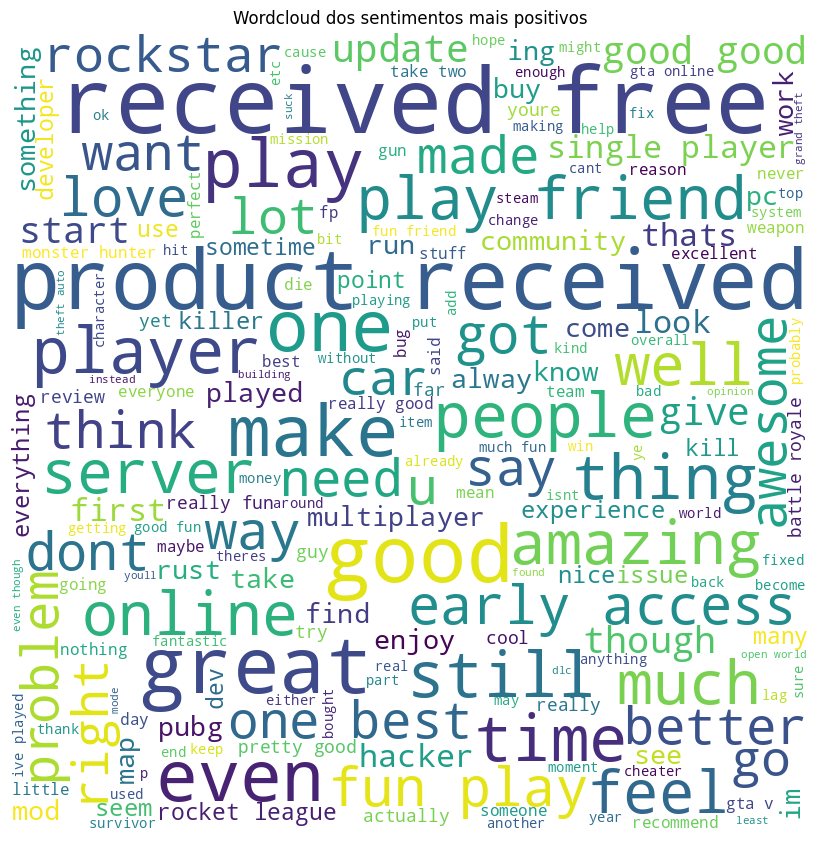

In [141]:
# wordcloud dos sentimentos mais positivos.
positive_reviews = df[df['sentiment_category'] == 'Positive']['summary'].tolist()
create_wordcloud(positive_reviews, "Wordcloud dos sentimentos mais positivos")

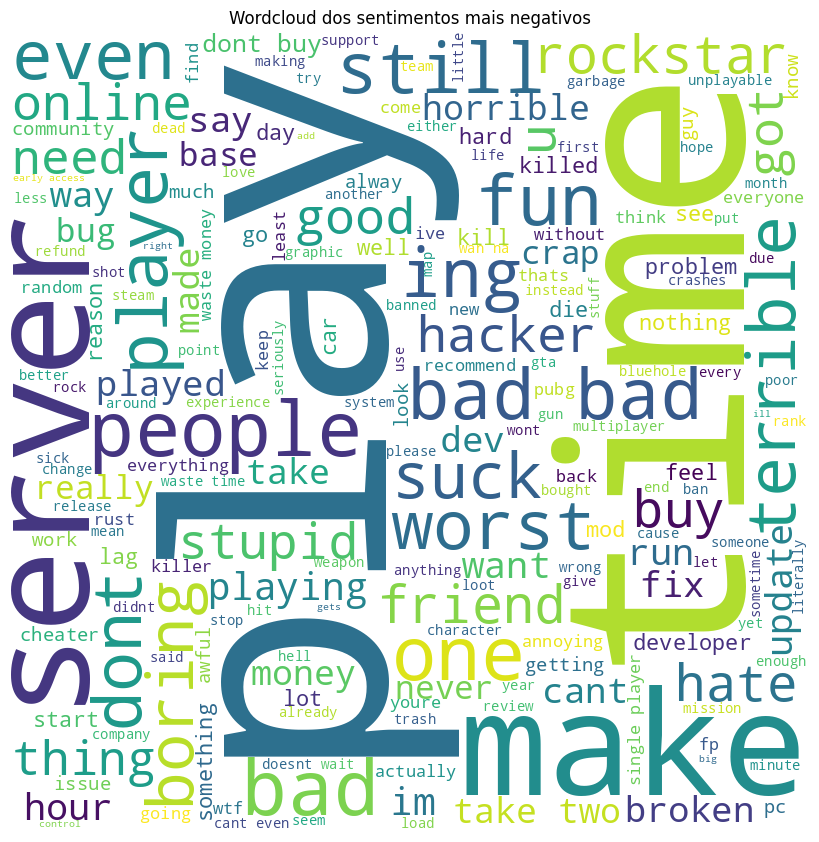

In [142]:
# wordcloud dos sentimentos mais negativos.
negative_reviews = df[df['sentiment_category'] == 'Negative']['summary'].tolist()
create_wordcloud(negative_reviews, "Wordcloud dos sentimentos mais negativos")

Wordcloud que mostra os jogos que geram mais sentimentos positivos e negativos.

In [143]:
positive_counts = df[df['sentiment_category'] == 'Positive'].groupby('title')['title'].count()
negative_counts = df[df['sentiment_category'] == 'Negative'].groupby('title')['title'].count()

df_pos = pd.DataFrame({'title': positive_counts.index, 'count': positive_counts.values})
df_neg = pd.DataFrame({'title': negative_counts.index, 'count': negative_counts.values})

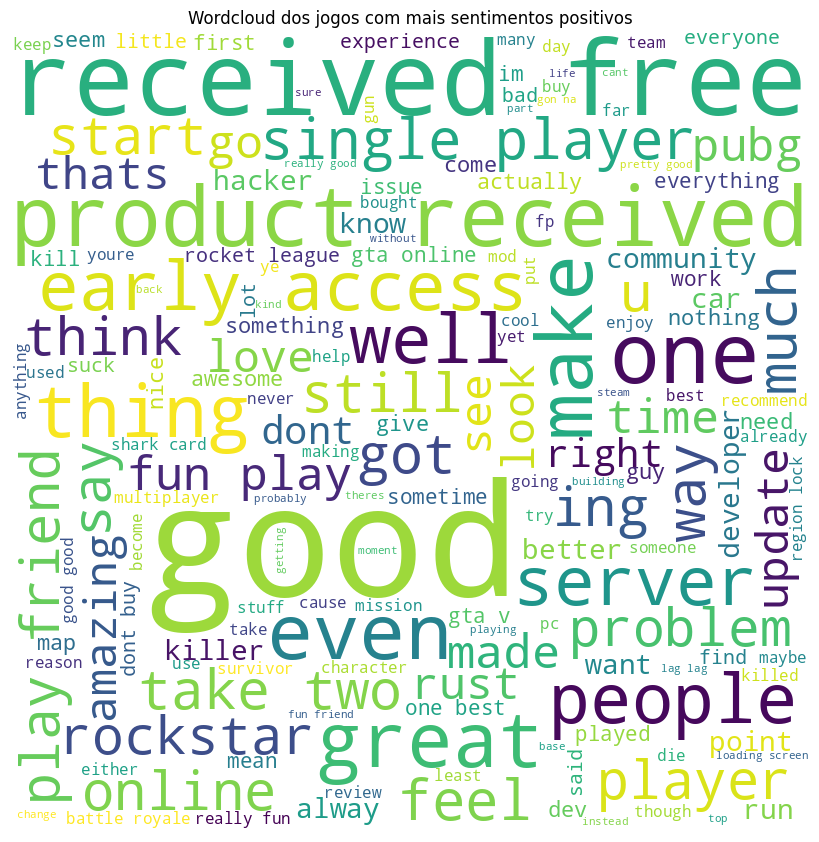

In [147]:
# wordcloud dos jogos com mais sentimentos positivos.
top_pos = df_pos.nlargest(5, 'count')
positive_games = top_pos['title'].tolist()
positive_reviews = df[df['title'].isin(positive_games)]['summary'].tolist()
create_wordcloud(positive_reviews, "Wordcloud dos jogos com mais sentimentos positivos")

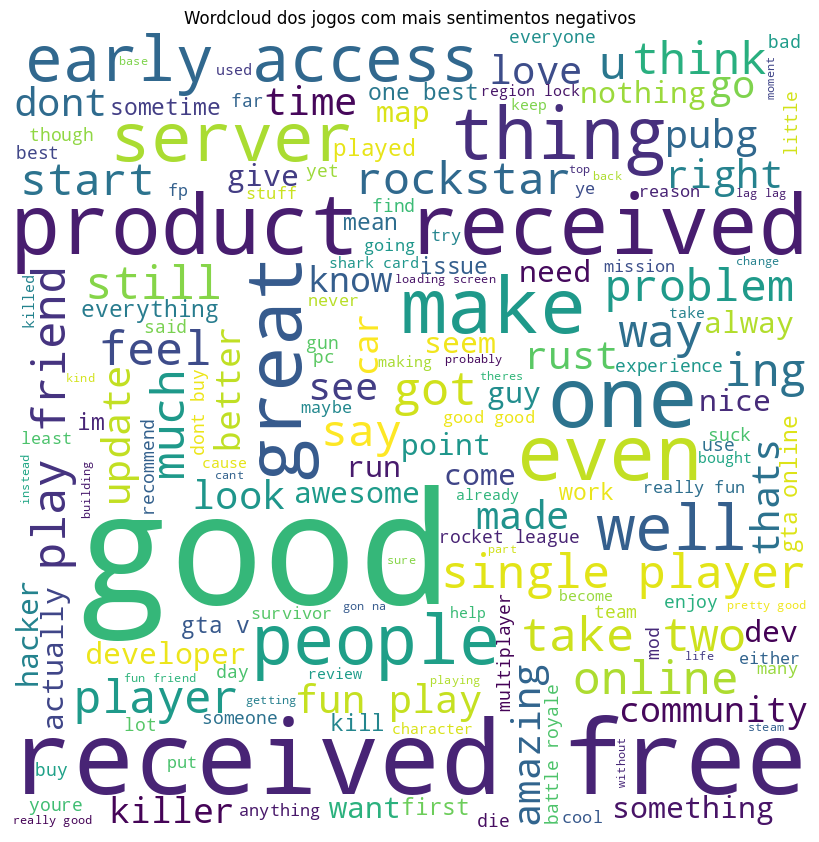

In [148]:
# wordcloud dos jogos com mais sentimentos negativos.
top_neg = df_neg.nlargest(5, 'count')
negative_games = top_neg['title'].tolist()
negative_reviews = df[df['title'].isin(negative_games)]['summary'].tolist()
create_wordcloud(negative_reviews, "Wordcloud dos jogos com mais sentimentos negativos")

Façamos algumas análises sobre os jogos:

* Análise de correlação, vendo a correlação entre o sentimento médio da review e a recomendação feita pelo usuário.
* Análise temporal, buscando os jogos que tiveram evolução no sentimento das reviews ao longo do tempo (análise nos jogos com maiores reviews positivos e negativos).
* Correlação entre total de horas, sentimento, recomendação e se o jogo estava em early access.

In [149]:
# Análise de correlação.
correlacao = df["ave_sentiment"].corr(df["recommendation"])
print("Correlação entre ave_sentiment e recommendation: ", correlacao)

Correlação entre ave_sentiment e recommendation:  0.39744467707540215


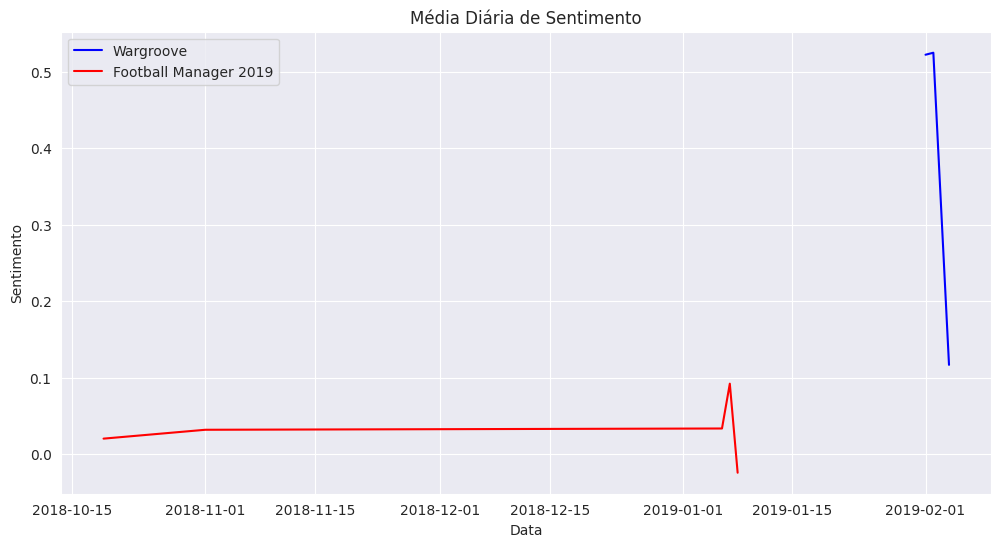

In [156]:
# Análise temporal.
import seaborn as sns

# Identificando o jogo com as reviews mais positivas.
most_positive_game = df.groupby(['title'])['sentiment'].mean().sort_values(ascending=False).reset_index().iloc[0]['title']

# Identificando o jogo com as reviews mais negativas.
most_negative_game = df.groupby(['title'])['sentiment'].mean().sort_values().reset_index().iloc[0]['title']

# Selecionando apenas as reviews dos jogos mais positivos e mais negativos.
most_positive_reviews = df[df['title'] == most_positive_game].copy()
most_negative_reviews = df[df['title'] == most_negative_game].copy()

# Criando coluna com a data da review.
most_positive_reviews['date_posted'] = pd.to_datetime(most_positive_reviews['date_posted'])
most_negative_reviews['date_posted'] = pd.to_datetime(most_negative_reviews['date_posted'])

# Calculando a média diária de sentimento para cada jogo.
most_positive_daily_sentiment = most_positive_reviews.groupby(['date_posted'])['sentiment'].mean()
most_negative_daily_sentiment = most_negative_reviews.groupby(['date_posted'])['sentiment'].mean()

# Plotando o gráfico.
sns.set_style("darkgrid")
plt.figure(figsize=(12,6))
plt.plot(most_positive_daily_sentiment.index, most_positive_daily_sentiment.values, color='blue')
plt.plot(most_negative_daily_sentiment.index, most_negative_daily_sentiment.values, color='red')
plt.legend([most_positive_game, most_negative_game])
plt.title('Média Diária de Sentimento')
plt.xlabel('Data')
plt.ylabel('Sentimento')
plt.show()

<Axes: >

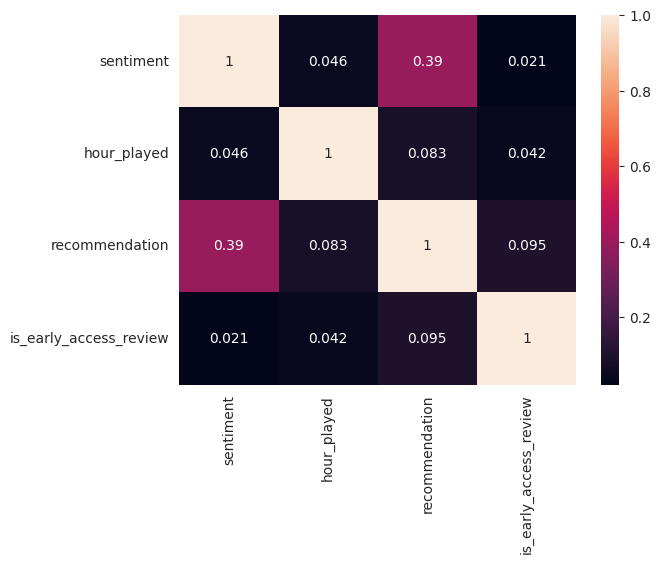

In [157]:
# Criando o heatmap para correlação entre total_hours, recommendation e is_early_access_review.
sns.heatmap(df[['sentiment', 'hour_played', 'recommendation', 'is_early_access_review']].corr(), annot=True)

#Modelagem de tópicos

Com a modelagem de tópicos, podemos coletar o feedback dos jogadores para cada jogo, de forma a mostrar para os desenvolvedores os pontos mais positivos e negativos de acordo com os reviews. Façamos isso utilizando LDA.

In [171]:
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel


# agrupa os resumos por jogo.
df_grouped = df.groupby('title')['summary'].apply(list).reset_index(name='summaries')

# cria um dicionário a partir dos resumos.
dictionary = corpora.Dictionary(df_grouped['summaries'])

# Transforma os resumos em um corpus.
corpus = [dictionary.doc2bow(summary) for summary in df_grouped['summaries']]

# Treina o modelo de LDA com o corpus.
num_topics = 5 # define o número de tópicos desejados.
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)

In [177]:
df_games = df.groupby('title').agg({'sentiment': 'mean', 'hour_played': 'sum', 'new_review': 'count'}).reset_index()
df_games = df_games.rename(columns={'sentiment': 'average_sentiment', 'hour_played': 'total_hours_played', 'new_review': 'review_count'})


# cria uma lista vazia para armazenar os tópicos de cada jogo.
topics_list = []

# itera sobre os jogos do dataframe agrupado.
for index, row in df_grouped.iterrows():
    
    # transforma o resumo em um bag-of-words.
    summary_bow = dictionary.doc2bow(row['summaries'])
    
    # atribui os tópicos ao resumo.
    topic_scores = lda_model[summary_bow]
    
    # ordena os tópicos por ordem decrescente de peso.
    sorted_topics = sorted(topic_scores, key=lambda x: x[1], reverse=True)
    
    # armazena apenas o tópico mais relevante.
    top_topic = sorted_topics[0][0]
    
    # adiciona o tópico à lista de tópicos.
    topics_list.append(lda_model.show_topic(top_topic, topn=5))

# adiciona a lista de tópicos como uma nova coluna do dataframe.
df_games['topics'] = topics_list

df_games

,title,average_sentiment,total_hours_played,review_count,topics
0,ACE COMBAT™ 7: SKIES UNKNOWN,0.100423,141,5,"[(good, 0.019021135), (, 0.01061469), (nice, 0..."
1,ARK: Survival Evolved,0.073453,90563,110,"[(good, 0.0056989426), (, 0.0023715864), (nice..."
2,ASTRONEER,0.297847,77105,1607,"[(good, 0.018649071), (nice, 0.007484391), (, ..."
3,Battlefleet Gothic: Armada 2,0.283378,296,6,"[(good, 0.00039806947), (great, 0.00019435419)..."
4,Beat Saber,0.224701,486,6,"[(good, 0.018649071), (nice, 0.007484391), (, ..."
5,Cold Waters,0.156244,1393,8,"[(good, 0.019021135), (, 0.01061469), (nice, 0..."
6,Dead by Daylight,0.221248,3588687,13281,"[(good, 0.0056989426), (, 0.0023715864), (nice..."
7,Divinity: Original Sin 2 - Definitive Edition,0.285953,14433,94,"[(good, 0.018649071), (nice, 0.007484391), (, ..."
8,Don't Starve Together,0.306183,18985,104,"[(good, 0.0056989426), (, 0.0023715864), (nice..."
9,Euro Truck Simulator 2,0.332831,60221,299,"[(good, 0.004896277), (nice, 0.0014427098), (g..."
